<a href="https://colab.research.google.com/github/jppgks/DL-from-Scratch-with-PyTorch/blob/main/MNIST_Digit_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import torch
from torch import nn
from torch.nn import functional as F

## Data

In [149]:
filenames = {
    "train": {
        "images": "train-images-idx3-ubyte.gz", 
        "labels": "train-labels-idx1-ubyte.gz"
    },
    "test": {
        "images": "t10k-images-idx3-ubyte.gz", 
        "labels": "t10k-labels-idx1-ubyte.gz"
    }
}

In [150]:
for fn in [fn for v in filenames.values() for fn in v.values()]:
  !wget -q "http://yann.lecun.com/exdb/mnist/{fn}"

In [151]:
import gzip
import numpy as np

images = dict()
labels = dict()

image_size = 28
for split, fns in filenames.items():
  num_samples = 60000 if split == "train" else 10000

  with gzip.open(fns["images"], 'r') as f:  
    f.read(16)
    buf = f.read(image_size * image_size * num_samples)
    data = torch.frombuffer(buf, dtype=torch.uint8).float()
    images[split] = data.reshape(num_samples, 1, image_size, image_size)
  
  with gzip.open(fns["labels"],'r') as f:
    f.read(8)
    buf = f.read(num_samples)
    labels[split] = torch.frombuffer(buf, dtype=torch.uint8).type(torch.int64)

In [152]:
images["train"].shape, labels["train"].shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [153]:
images["test"].shape, labels["test"].shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

tensor(7)


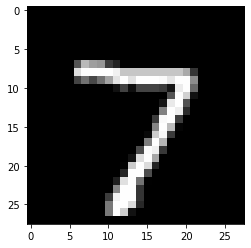

In [155]:
import matplotlib.pyplot as plt

def plot_test_img(i: int):
  print(labels["test"][i])
  image = images["test"][i].squeeze().numpy()
  plt.imshow(image, cmap="gray")
  plt.show()

plot_test_img(0)

## Model

In [119]:
class ImageClassifier(nn.Module):
  out_channels = 32
  kernel_size = 3
  stride = 1
  padding = 1

  def __init__(self, in_channels, width, height, num_classes):
    super(ImageClassifier, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)

    self.flatten = nn.Flatten()
    self.cls_head = nn.Linear(self.out_channels * (width // 2) * (height // 2), num_classes)
  
  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.activation(x)
    assert x.shape[2:] == inputs.shape[2:]

    x = self.pool(x)
    assert x.shape[2] == (inputs.shape[2] // 2)
    assert x.shape[3] == (inputs.shape[3] // 2)

    out = self.cls_head(self.flatten(x))

    return out

In [120]:
model = ImageClassifier(in_channels=1, width=28, height=28, num_classes=len(labels["train"].unique()))

In [121]:
model(images["train"][:2])

tensor([[  8.5442,   6.2514, -10.9981,  22.5418, -13.0837,  -9.0850, -10.5234,
           6.5593,  -0.7001, -14.6719],
        [-10.0452,  16.7046, -21.3923,  54.1753, -10.7558,   6.7363,  -4.8050,
          11.5664,   9.4118,  28.9595]], grad_fn=<AddmmBackward0>)

## Optimization

In [122]:
dataset = torch.utils.data.TensorDataset(images["train"], labels["train"])

In [123]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [128]:
X, y = next(iter(dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [142]:
pred = model(X)
assert torch.argmax(F.softmax(pred, dim=1), dim=1).shape == y.shape

In [143]:
loss_fn = nn.CrossEntropyLoss()

In [144]:
loss_fn(pred, y)

tensor(33.9488, grad_fn=<NllLossBackward0>)

In [138]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [145]:
epochs = 1
for _ in range(epochs):
  for (X, y) in dataloader:
    optimizer.zero_grad()

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()

## Inference

tensor(7)


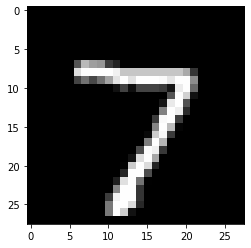

In [156]:
plot_test_img(0)

In [159]:
torch.argmax(F.softmax(model(images["test"][:1]), dim=1), dim=1)

tensor([7])

In [ ]:
X, y = next(iter(dataloader))

In [146]:
y

tensor([0, 5, 7, 9, 5, 6, 4, 8, 3, 9, 8, 9, 1, 2, 0, 6, 4, 9, 6, 2, 3, 4, 1, 2,
        8, 4, 0, 1, 1, 3, 1, 5])

In [148]:
torch.argmax(F.softmax(model(X), dim=1), dim=1)

tensor([0, 5, 7, 9, 5, 6, 4, 8, 3, 9, 8, 9, 1, 2, 0, 6, 4, 9, 6, 2, 3, 4, 1, 2,
        8, 4, 0, 1, 1, 3, 1, 5])

## Evaluation metrics

In [160]:
pred_test = model(images["test"])

In [161]:
pred_test = torch.argmax(F.softmax(pred_test, dim=1), dim=1)

In [162]:
pred_test.shape, labels["test"].shape

(torch.Size([10000]), torch.Size([10000]))

In [164]:
from sklearn.metrics import classification_report

print(classification_report(labels["test"], pred_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       980
           1       0.98      0.97      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.98      0.88      0.93      1010
           4       0.99      0.80      0.89       982
           5       0.98      0.90      0.94       892
           6       0.96      0.95      0.96       958
           7       0.98      0.71      0.82      1028
           8       0.85      0.96      0.91       974
           9       0.66      0.98      0.79      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

